In [1]:
import numpy as np

from statespace.models import BrownianConstantVelocityModel, NVMConstantVelocityModel, BrownianLangevinModel, NVMLangevinModel

from stochastic.processes import GammaProcess, TemperedStableProcess, GeneralisedInverseGaussianProcess

from statespace.methods import KalmanFilter, SequentialCollapsedGaussianMCMCFilter, MarginalisedParticleFilter

import pandas as pd
import matplotlib.pyplot as plt

# Langevin model example:

In [2]:
N = 500
D = 2
D_prime = 1
n_particles = 1

times = np.linspace(start=0, stop=100, num=N).reshape(N, 1)

##################################
# Initial distribution definition.
##################################

x_init = np.random.normal(loc=0., scale=0.1, size=(D, 1))
#x_init = np.random.normal(loc=0., scale=0.1, size=(n_particles, D, 1))

##################################
# State transition dynamics.
##################################

theta = -0.5
mu = 0.
sigma = 1.0
# subordinator = GammaProcess(**{"beta":1., "C":1.})
# subordinator = TemperedStableProcess(**{"alpha":0.6, "beta":0.1, "C":0.5})
subordinator = GeneralisedInverseGaussianProcess(**{"lam":-0.4, "gamma":0.01, "delta":1.0})

##################################
# Observation model.
##################################

sigma_eps = 1.0

##################################
# Langevin model.
##################################

model = NVMLangevinModel(**{"subordinator":subordinator, "theta":theta, "mu":mu, "sigma":sigma, "sigma_eps":sigma_eps})

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to improved version for 0 < |lam| < 0.5.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


In [3]:
X, Y, t_series, x_series = model.sample(times, x_init, n_particles=n_particles)

/Users/yaman/models/stochastic/processes.py:42: RuntimeWarning: overflow encountered in exp
  return 1/(self.beta*(np.exp(gamma/self.C)-1))
/Users/yaman/models/stochastic/processes.py:1174: RuntimeWarning: invalid value encountered in divide
  envelope_fnc = (((2*self.delta**2)**self.abs_lam)* incgammal(self.abs_lam, (z0**2)*x_series[i]/(2*self.delta**2))*self.abs_lam*(1+self.abs_lam)/
/Users/yaman/models/stochastic/processes.py:1155: RuntimeWarning: invalid value encountered in divide
  envelope_fnc = (((2*self.delta**2)**self.abs_lam)* incgammal(self.abs_lam, (z0**2)*x_series[i]/(2*self.delta**2))*self.abs_lam*(1+self.abs_lam)/


In [4]:
# np.load("datasets/levy_ssm/gig-synthetic/t_series.npy")

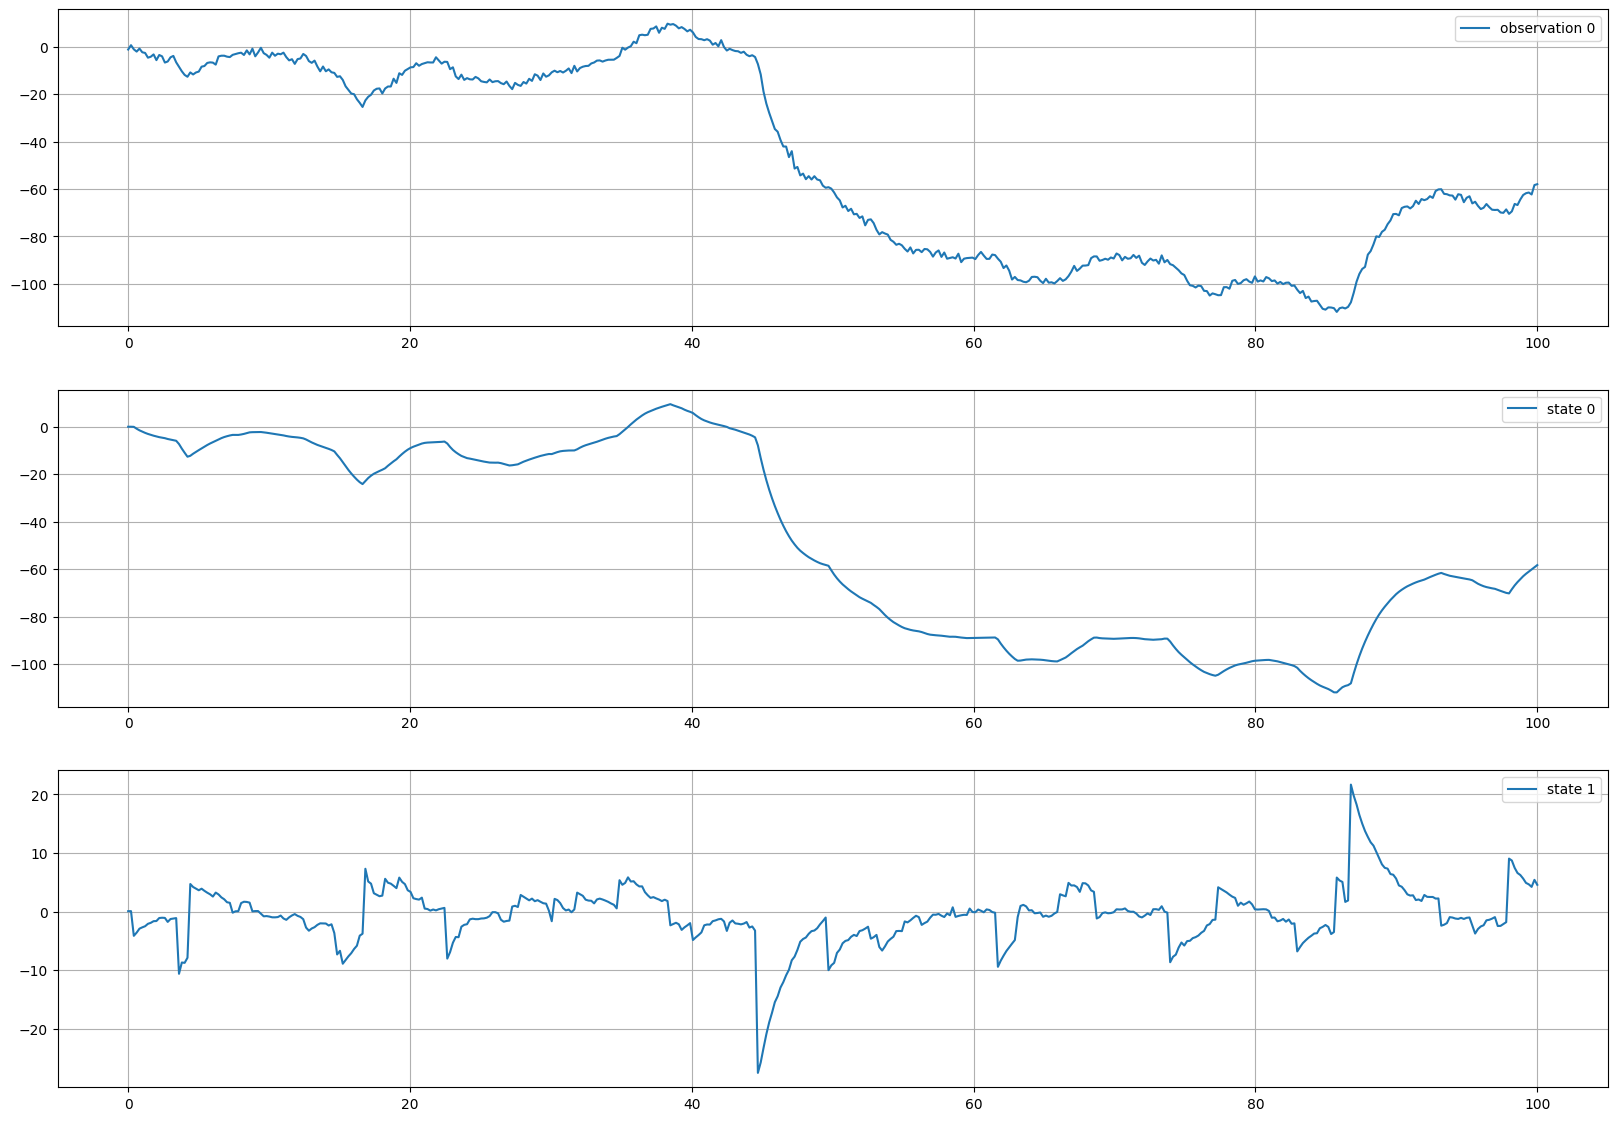

In [5]:
fig, ax = plt.subplots(nrows=(X.shape[-2] + Y.shape[-2]), ncols=n_particles, figsize=(20,14))

if (n_particles > 1):

    for particle_idx in range(n_particles):
        i = 0

        for j in range(Y.shape[-2]):
            ax[i][particle_idx].plot(times, Y[:,particle_idx, j,:], label=f'observation {j}')
            ax[i][particle_idx].grid(True)
            ax[i][particle_idx].legend()
            i += 1

        for j in range(X.shape[-2]):
            ax[i][particle_idx].plot(times, X[:,particle_idx, j,:], label=f'state {j}')
            ax[i][particle_idx].grid(True)
            ax[i][particle_idx].legend()
            i += 1

else:
    for particle_idx in range(n_particles):
        i = 0

        for j in range(Y.shape[-2]):
            ax[i].plot(times, Y[:,particle_idx, j,:], label=f'observation {j}')
            ax[i].grid(True)
            ax[i].legend()
            i += 1

        for j in range(X.shape[-2]):
            ax[i].plot(times, X[:,particle_idx, j,:], label=f'state {j}')
            ax[i].grid(True)
            ax[i].legend()
            i += 1

# plt.tight_layout()
plt.show()

In [6]:
# y_axis_lims = [-10, 6]

## Kalman filtering:

In [7]:
##################################
# Initial distribution definition.
##################################

x_init_gaussian = np.random.normal(loc=0., scale=0.1, size=(D, 1))
# x_init = np.random.normal(loc=0., scale=1., size=(n_particles, D, 1))

C_init_gaussian = 1*np.eye(D)

##################################
# State transition dynamics.
##################################

theta_gaussian = theta
sigma_gaussian = sigma

##################################
# Observation model.
##################################

sigma_eps_gaussian = sigma_eps

##################################
# Langevin model.
##################################

model_gaussian = BrownianLangevinModel(**{"theta":theta_gaussian, "sigma":sigma_gaussian, "sigma_eps":sigma_eps_gaussian})

observations = Y[:,0,:]
inference_module_gaussian = KalmanFilter(model=model_gaussian, prior=None, proposal=None)

The prior configuration is not valid.


In [8]:
memory_gaussian = inference_module_gaussian.filter(times, observations, x_init_gaussian, C_init_gaussian)

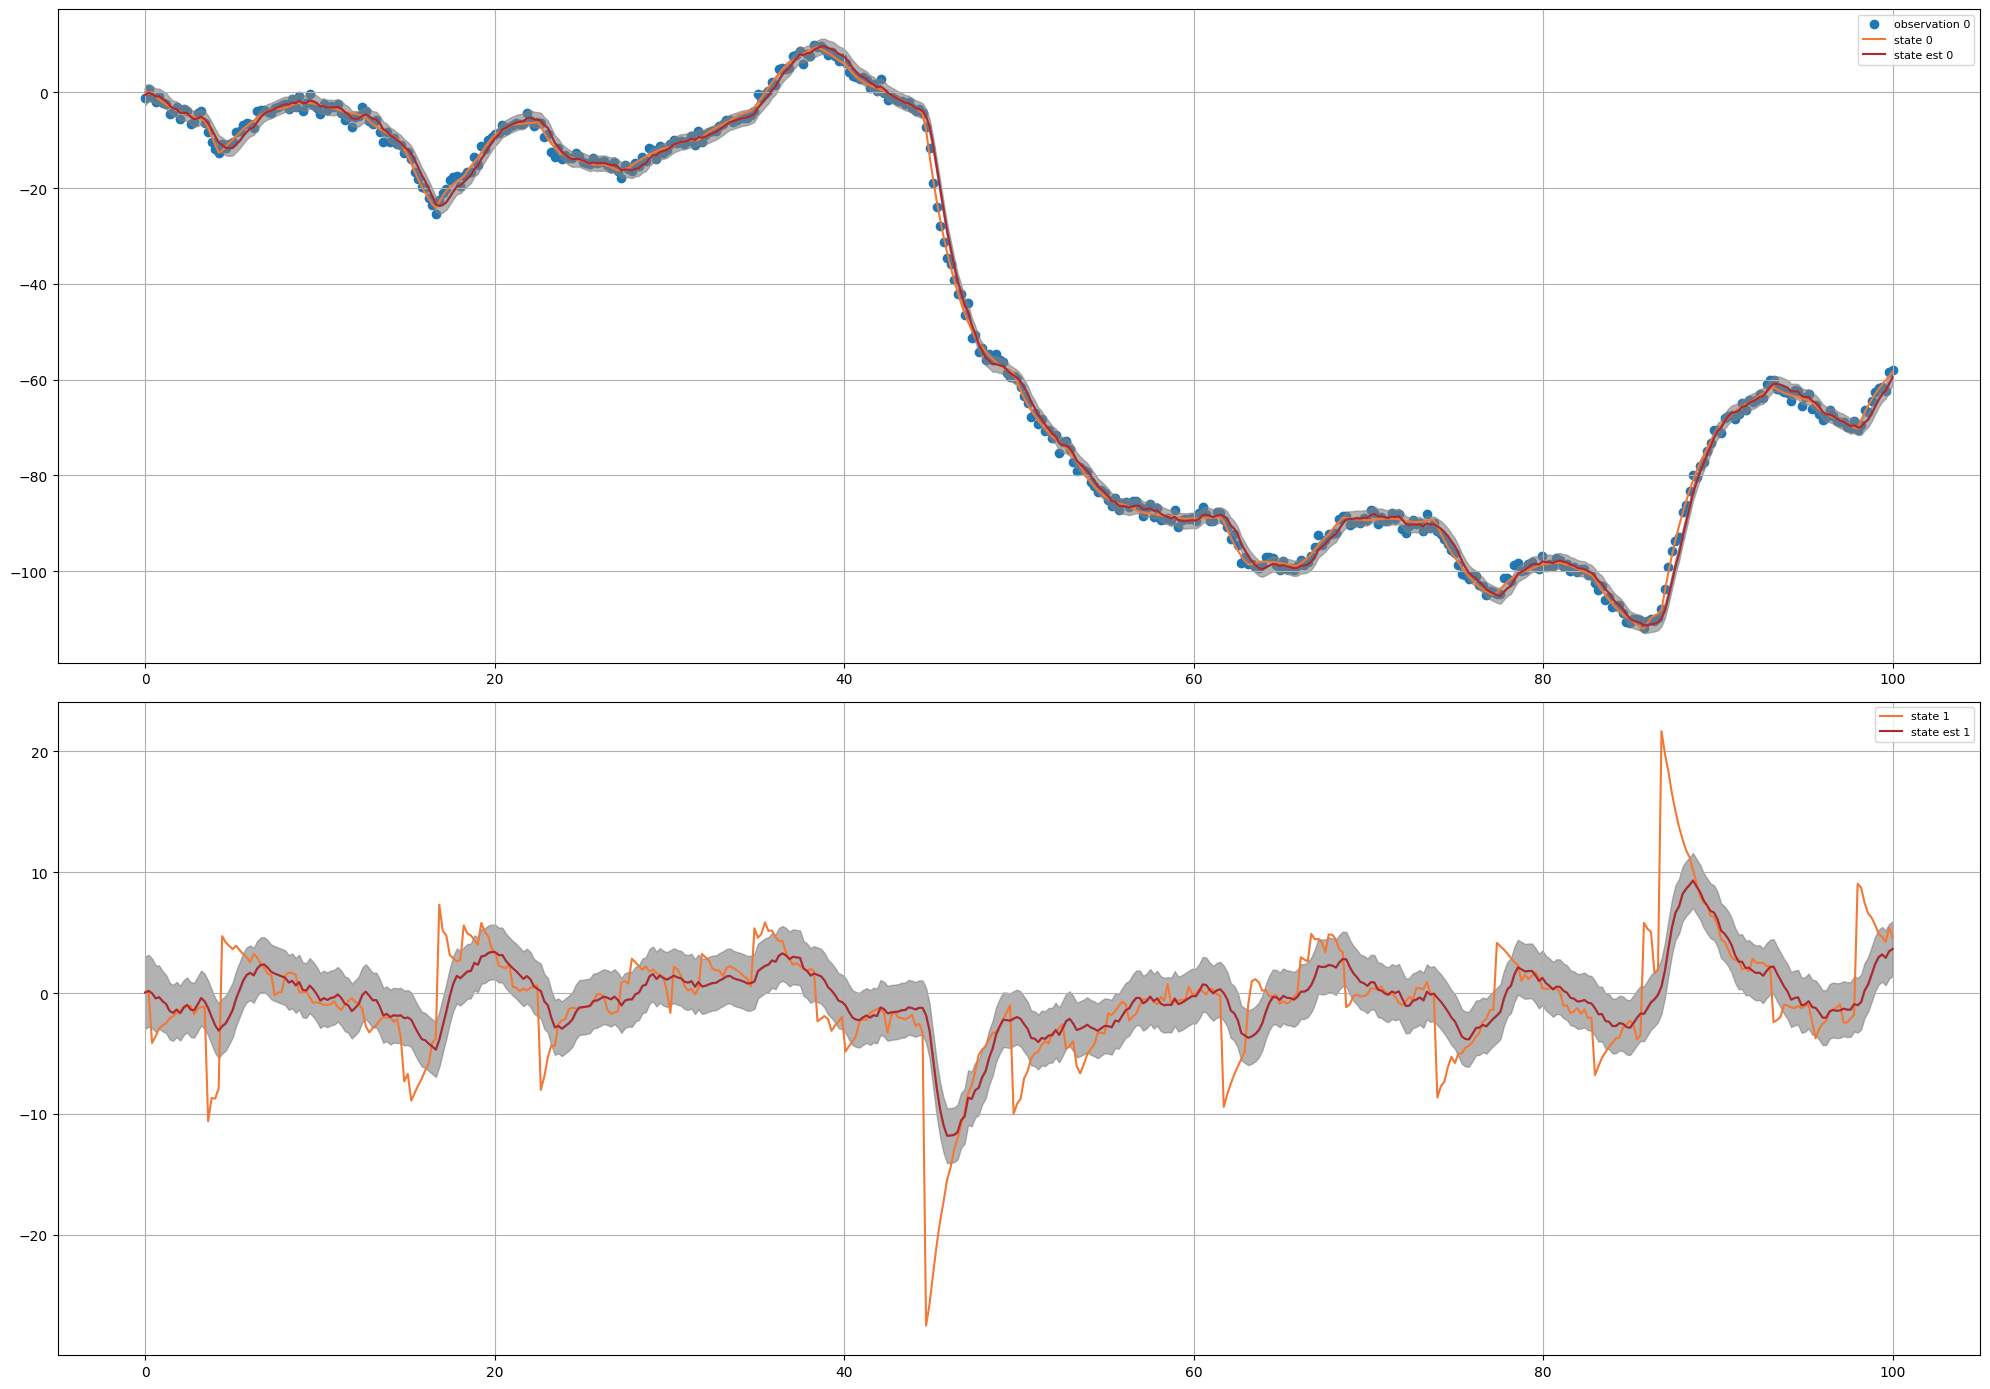

In [9]:
n_particles = 1
fig, ax = plt.subplots(nrows=(X.shape[-2]), ncols=n_particles, figsize=(20,14))

if (n_particles > 1):

    for particle_idx in range(n_particles):
        i = 0

        for j in range(Y.shape[-2]):
            ax[i][particle_idx].plot(times, Y[:,particle_idx, j,:], label=f'observation {j}')
            ax[i][particle_idx].grid(True)
            ax[i][particle_idx].legend()
            i += 1

        for j in range(X.shape[-2]):
            ax[i][particle_idx].plot(times, X[:,particle_idx, j,:], label=f'state {j}')
            ax[i][particle_idx].plot(times, memory_gaussian['filtered_mean'][:,j,:], label=f'state est {j}')
            ax[i][particle_idx].fill_between(times.flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten() + 3 * np.sqrt(memory_gaussian['filtered_cov'][:,0,0]), alpha=0.6, color='grey')
            ax[i][particle_idx].fill_between(times.flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten() - 3 * np.sqrt(memory_gaussian['filtered_cov'][:,0,0]), alpha=0.6, color='grey')
            ax[i][particle_idx].grid(True)
            ax[i][particle_idx].legend()
            i += 1

else:
    for particle_idx in range(n_particles):
        i = 0

        # for j in range(Y.shape[-2]):
        #     ax[i].plot(times, Y[:,particle_idx, j,:], label=f'observation {j}')
        #     ax[i].grid(True)
        #     ax[i].legend()
        #     i += 1

        for j in range(X.shape[-2]):
            if i == 0:
                ax[i].scatter(times, Y[:,particle_idx, j,:], label=f'observation {j}')

            ax[i].plot(times, X[:,particle_idx, j,:], label=f'state {j}', c="#f37735")
            ax[i].plot(times, memory_gaussian['filtered_mean'][:,j,:], label=f'state est {j}', c="#af272f")
            ax[i].fill_between(times.flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten() + 3 * np.sqrt(memory_gaussian['filtered_cov'][:,j,j]), alpha=0.6, color='grey')
            ax[i].fill_between(times.flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten(), memory_gaussian['filtered_mean'][:,j,:].flatten() - 3 * np.sqrt(memory_gaussian['filtered_cov'][:,j,j]), alpha=0.6, color='grey')

            # if (j == 1):
            #     ax[i].set_ylim(y_axis_lims[0], y_axis_lims[1])

            ax[i].grid(True)
            ax[i].legend(fontsize=8)
            i += 1

plt.tight_layout()
plt.show()

## Sequential Collapsed Gaussian MCMC:

In [10]:
##################################
# Initial distribution definition.
##################################

x_init_levy = np.random.normal(loc=0., scale=0.1, size=(D, 1))
# x_init = np.random.normal(loc=0., scale=1., size=(n_particles, D, 1))

C_init_levy = np.random.normal(loc=0., scale=0.1, size=(D, D))
C_init_levy = C_init_levy.T @ C_init_levy

##################################
# State transition dynamics.
##################################

theta_levy = theta
mu_levy = mu
sigma_levy = sigma

# subordinator_levy = GammaProcess(**{"beta":1., "C":1.})
# subordinator_levy = TemperedStableProcess(**{"alpha":0.6, "beta":0.1, "C":0.5})
subordinator_levy = GeneralisedInverseGaussianProcess(**{"lam":-0.4, "gamma":0.01, "delta":1.0})

##################################
# Observation model.
##################################

sigma_eps_levy = sigma_eps

##################################
# Langevin model.
##################################

model_levy = NVMLangevinModel(**{"subordinator":subordinator_levy, "theta":theta_levy, "mu":mu_levy, "sigma":sigma_levy, "sigma_eps":sigma_eps_levy})

observations = Y[:,0,:]
inference_module = SequentialCollapsedGaussianMCMCFilter(model=model_levy, prior=None, proposal=None)

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to improved version for 0 < |lam| < 0.5.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.
The prior configuration is not valid.


In [11]:
memory, chain = inference_module.filter(times, observations, x_init_levy, C_init_levy, n_samples=100, burn_in=0)

0.988356956943134


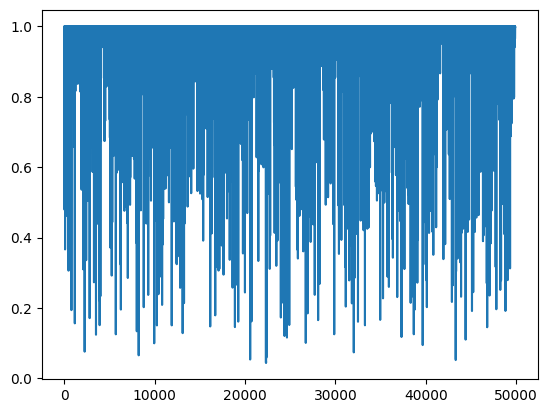

In [12]:
print(np.array(inference_module.acceptance_rates).mean())
plt.plot(np.array(inference_module.acceptance_rates));

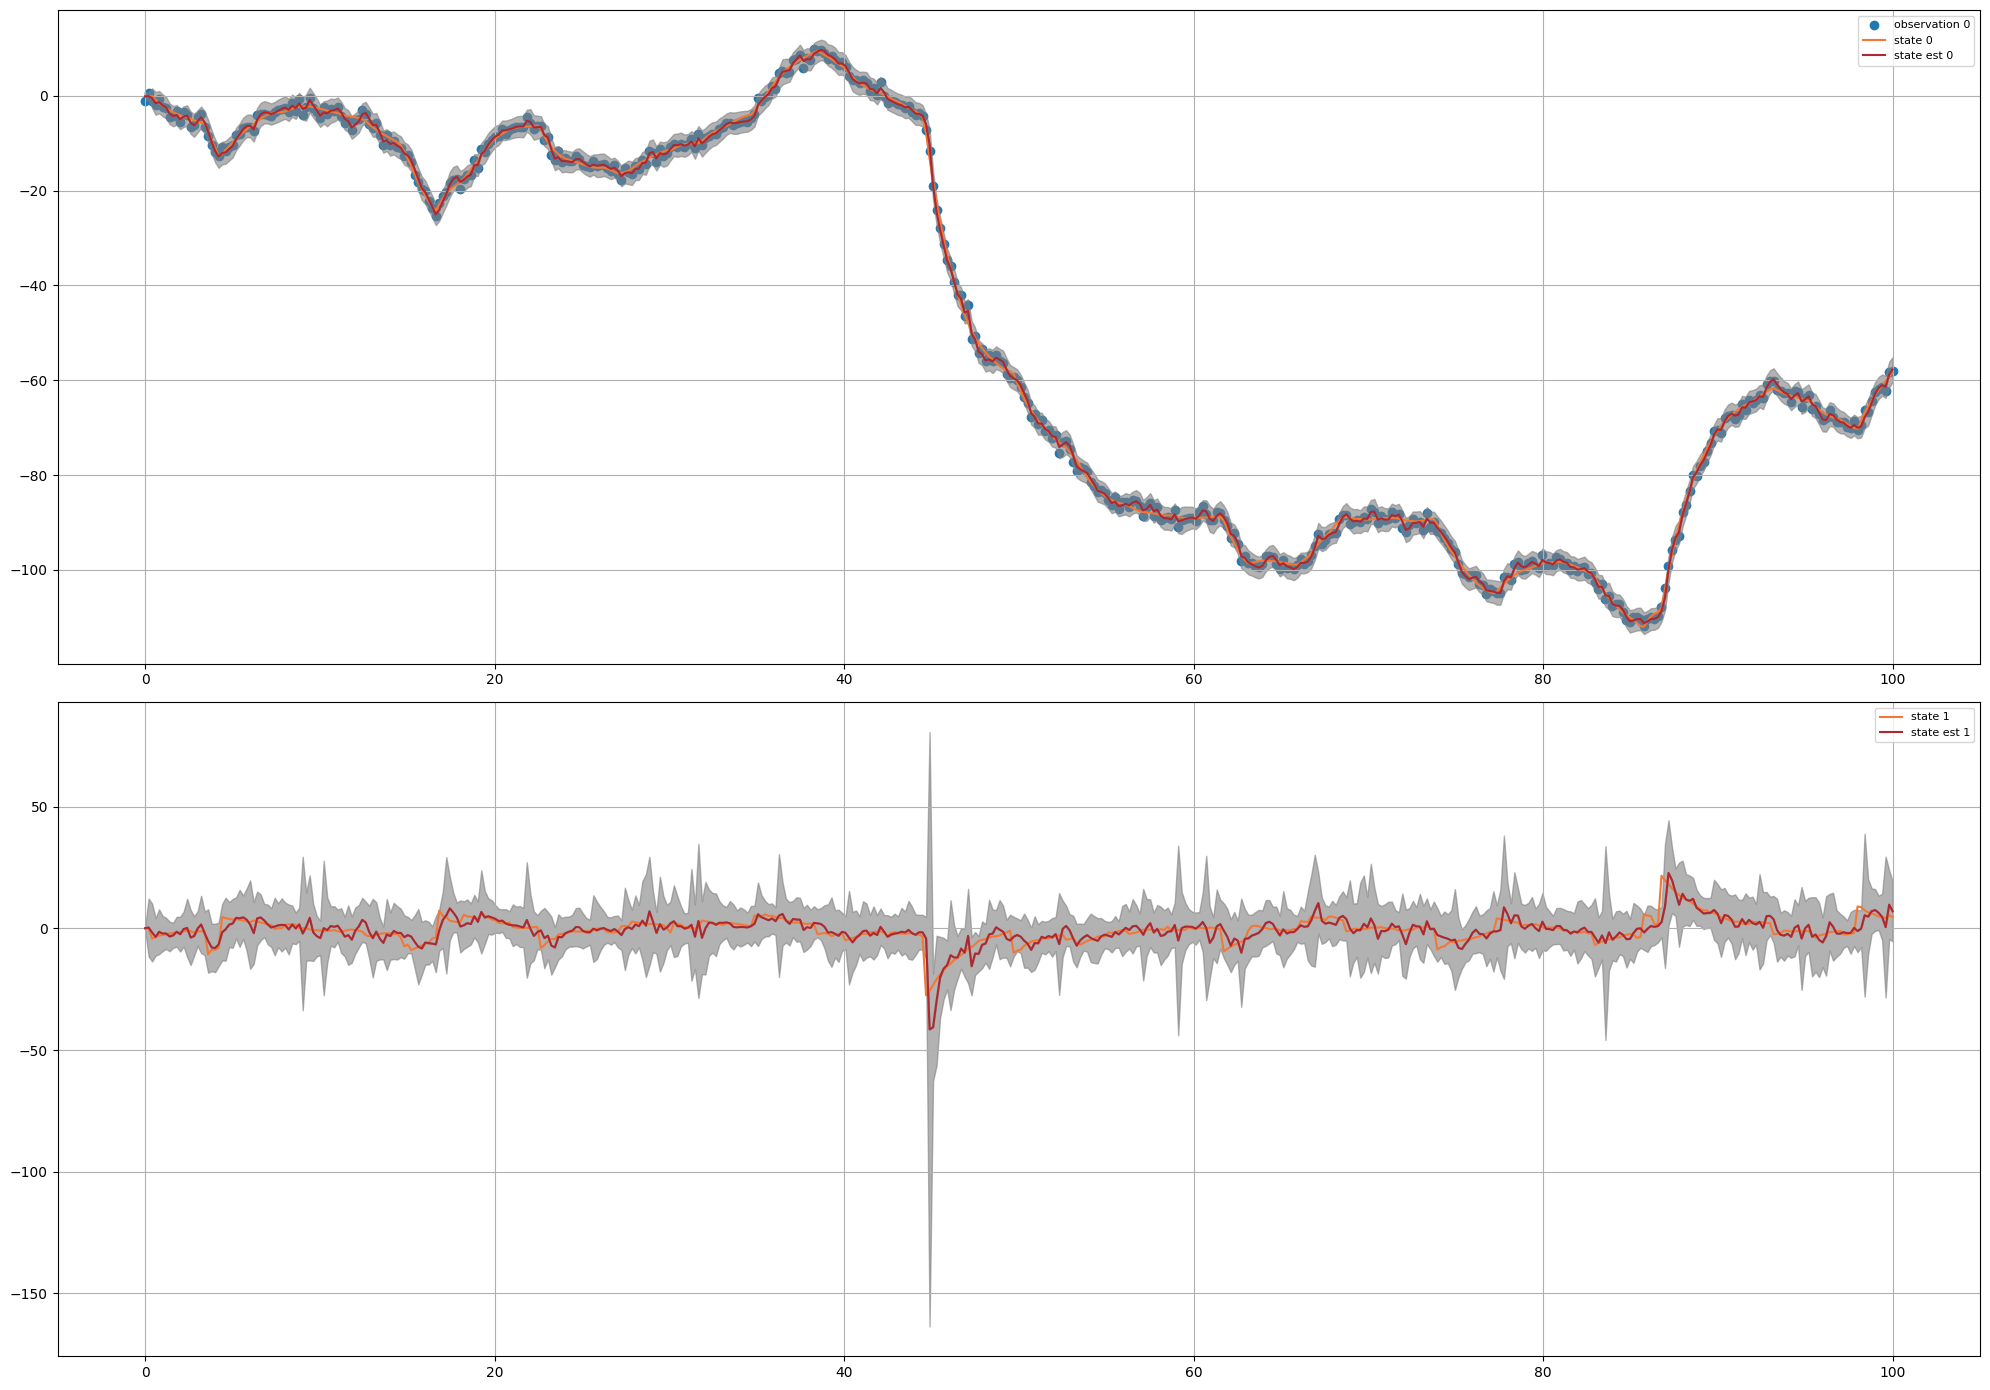

In [14]:
fig, ax = plt.subplots(nrows=(X.shape[-2]), ncols=n_particles, figsize=(20,14))

if (n_particles > 1):

    for particle_idx in range(n_particles):
        i = 0

        for j in range(Y.shape[-2]):
            ax[i][particle_idx].plot(times, Y[:,particle_idx, j,:], label=f'observation {j}')
            ax[i][particle_idx].grid(True)
            ax[i][particle_idx].legend()
            i += 1

        for j in range(X.shape[-2]):
            ax[i][particle_idx].plot(times, X[:,particle_idx, j,:], label=f'state {j}')
            ax[i][particle_idx].plot(times, memory['filtered_mean'][:,j,:], label=f'state est {j}')
            ax[i][particle_idx].fill_between(times.flatten(), memory['filtered_mean'][:,j,:].flatten(), memory['filtered_mean'][:,j,:].flatten() + 3 * np.sqrt(memory['filtered_cov'][:,0,0]), alpha=0.6, color='grey')
            ax[i][particle_idx].fill_between(times.flatten(), memory['filtered_mean'][:,j,:].flatten(), memory['filtered_mean'][:,j,:].flatten() - 3 * np.sqrt(memory['filtered_cov'][:,0,0]), alpha=0.6, color='grey')
            ax[i][particle_idx].grid(True)
            ax[i][particle_idx].legend()
            i += 1

else:
    for particle_idx in range(n_particles):
        i = 0

        # for j in range(Y.shape[-2]):
        #     ax[i].plot(times, Y[:,particle_idx, j,:], label=f'observation {j}')
        #     ax[i].grid(True)
        #     ax[i].legend()
        #     i += 1

        for j in range(X.shape[-2]):
            if i == 0:
                ax[i].scatter(times, Y[:,particle_idx, j,:], label=f'observation {j}')
            ax[i].plot(times, X[:,particle_idx, j,:], label=f'state {j}', c="#f37735")
            ax[i].plot(times, memory['filtered_mean'][:,j,:], label=f'state est {j}', c="#af272f")
            ax[i].fill_between(times.flatten(), memory['filtered_mean'][:,j,:].flatten(), memory['filtered_mean'][:,j,:].flatten() + 3 * np.sqrt(memory['filtered_cov'][:,j,j]), alpha=0.6, color='grey')
            ax[i].fill_between(times.flatten(), memory['filtered_mean'][:,j,:].flatten(), memory['filtered_mean'][:,j,:].flatten() - 3 * np.sqrt(memory['filtered_cov'][:,j,j]), alpha=0.6, color='grey')

            # if (j == 1):
            #     ax[i].set_ylim(y_axis_lims[0], y_axis_lims[1])

            ax[i].grid(True)
            ax[i].legend(fontsize=8)
            i += 1

plt.tight_layout()
plt.show()

## Marginalised Particle Filtering:

In [16]:
##################################
# Initial distribution definition.
##################################

x_init_levy = np.random.normal(loc=0., scale=0.1, size=(D, 1))
# x_init = np.random.normal(loc=0., scale=1., size=(n_particles, D, 1))

C_init_levy = np.random.normal(loc=0., scale=0.1, size=(D, D))
C_init_levy = C_init_levy.T @ C_init_levy

##################################
# State transition dynamics.
##################################

theta_levy = theta
mu_levy = mu
sigma_levy = sigma

# subordinator_levy = GammaProcess(**{"beta":1., "C":1.})
# subordinator_levy = TemperedStableProcess(**{"alpha":0.6, "beta":0.1, "C":0.5})
subordinator_levy = GeneralisedInverseGaussianProcess(**{"lam":-0.4, "gamma":0.01, "delta":1.0})

##################################
# Observation model.
##################################

sigma_eps_levy = sigma_eps

##################################
# Langevin model.
##################################

model_levy = NVMLangevinModel(**{"subordinator":subordinator_levy, "theta":theta_levy, "mu":mu_levy, "sigma":sigma_levy, "sigma_eps":sigma_eps_levy})

observations = Y[:,0,:]
inference_module = MarginalisedParticleFilter(model=model_levy, prior=None, proposal=None)
n_particles = 100

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to improved version for 0 < |lam| < 0.5.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.
The prior configuration is not valid.


In [17]:
memory = inference_module.filter(times, observations, x_init_levy, C_init_levy, n_particles=n_particles)

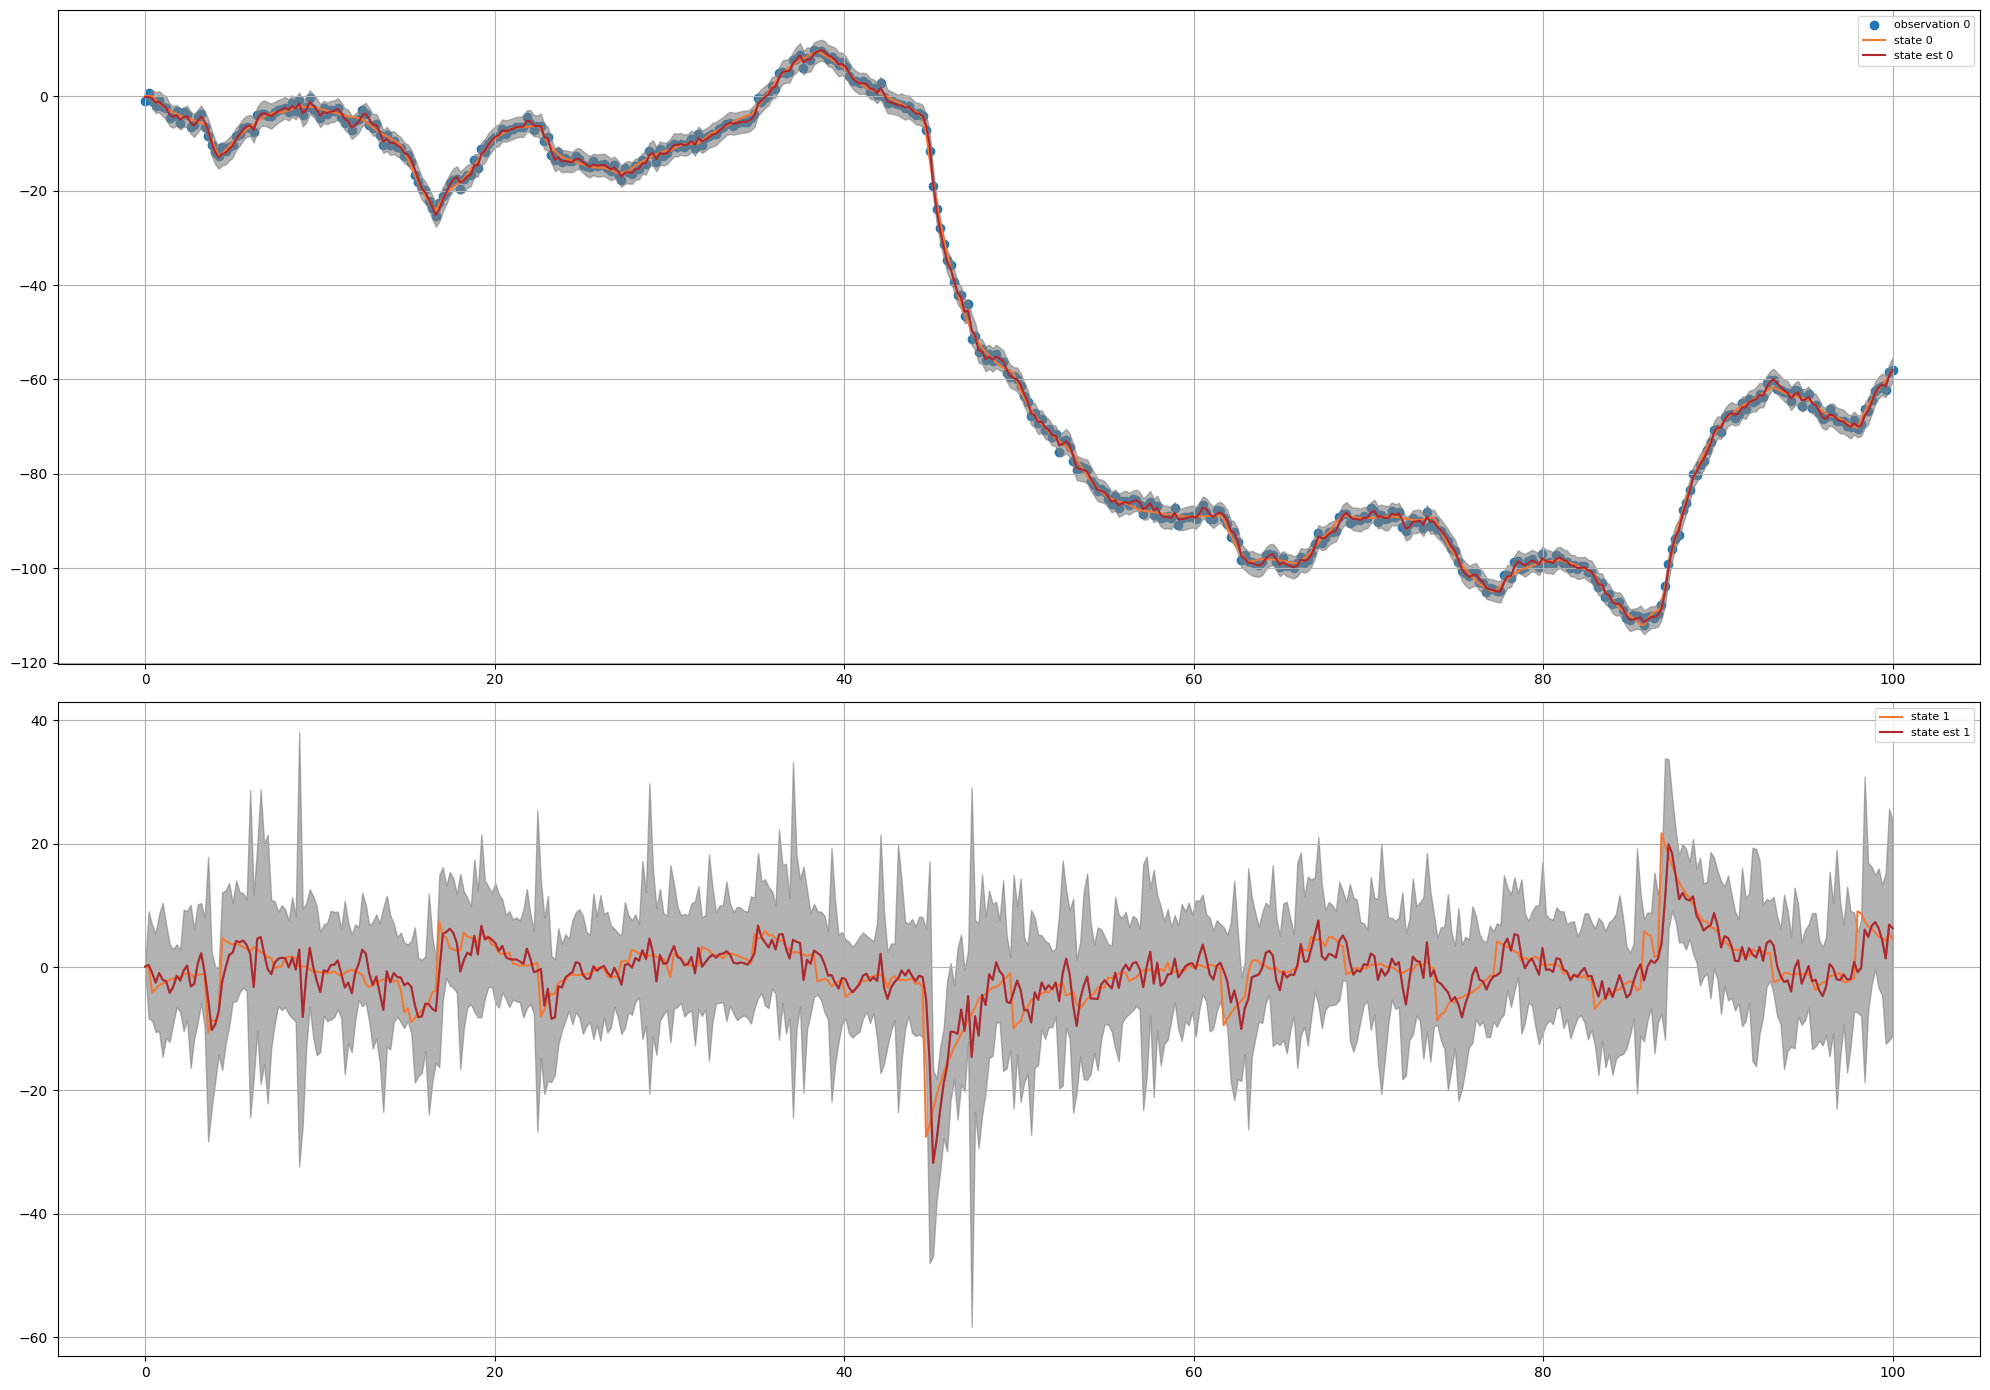

In [18]:
fig, ax = plt.subplots(nrows=(X.shape[-2]), ncols=1, figsize=(20,14))

i = 0
for j in range(X.shape[-2]):
    if i == 0:
        ax[i].scatter(times, Y[:,0, j,:], label=f'observation {j}')
    ax[i].plot(times, X[:,0, j,:], label=f'state {j}', c="#f37735")
    ax[i].plot(times, memory['filtered_mean'][:,j,:], label=f'state est {j}', c="#af272f")
    ax[i].fill_between(times.flatten(), memory['filtered_mean'][:,j,:].flatten(), memory['filtered_mean'][:,j,:].flatten() + 3 * np.sqrt(memory['filtered_cov'][:,j,j]), alpha=0.6, color='grey')
    ax[i].fill_between(times.flatten(), memory['filtered_mean'][:,j,:].flatten(), memory['filtered_mean'][:,j,:].flatten() - 3 * np.sqrt(memory['filtered_cov'][:,j,j]), alpha=0.6, color='grey')

    # if (j == 1):
    #     ax[i].set_ylim(y_axis_lims[0], y_axis_lims[1])

    ax[i].grid(True)
    ax[i].legend(fontsize=8)
    i += 1

plt.tight_layout()
plt.show()